In [1]:
%load_ext autoreload
%autoreload 2
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm

In [3]:
tt = SMTT()

In [2]:
autoenc = models.SparseAutoEncoder(512, 1024).to("cuda")

loss_fn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(autoenc.parameters(), lr=1e-4, weight_decay=1e-3)

In [3]:
act_data = torch.load("all_games_act_data.pt")

In [7]:
act_data[0].mean()

tensor(0.6646)

In [11]:
test = loss_fn(torch.zeros(2, 2), torch.ones(2, 2), reduction="none")
test

tensor([[1., 1.],
        [1., 1.]])

### Getting a sparser encoder! (actually following instructions)
- L0 around 10 or 20 on average across 1000 games
- feature density is mostly under 1%
- reconstruction loss stays low

In [4]:
epochs = 30
batch_size = 2**15
lam = 1e-7
losses = []
for epoch in range(epochs):
    for batch in range(0, act_data.shape[0], batch_size):
        dat = act_data[batch : batch + batch_size].to("cuda")

        l0, reg, guess = autoenc(dat)
        mse_loss = loss_fn(guess, dat)

        sparse_loss = lam * reg
        # sparse_loss = 0
        loss = mse_loss + sparse_loss
        # losses.append(interpretability.numpy(loss))
        losses.append([mse_loss.item(), sparse_loss.item(), l0.item()])
        optimizer.zero_grad()
        loss.backward()
        print(losses[-1])
        optimizer.step()

        with torch.no_grad():
            last_loss = loss_fn(guess, dat, reduction="none")

[3.8829078674316406, 1.5043699741363525, 515.718017578125]
[3.5125527381896973, 1.4553755521774292, 510.5257873535156]
[3.2030467987060547, 1.4119622707366943, 503.58221435546875]
[3.003427028656006, 1.3559772968292236, 489.9543762207031]
[2.595529317855835, 1.2802245616912842, 474.7830810546875]
[2.4469361305236816, 1.25418221950531, 470.4475402832031]
[2.3016197681427, 1.2208279371261597, 462.93011474609375]
[2.118614673614502, 1.1729393005371094, 452.8814392089844]
[1.8115085363388062, 1.1226959228515625, 447.13665771484375]
[1.7032968997955322, 1.0890953540802002, 444.4722595214844]
[1.6257213354110718, 1.0704108476638794, 436.6492614746094]
[1.5792932510375977, 1.050442099571228, 428.34234619140625]
[1.4732829332351685, 0.9978772401809692, 420.72528076171875]
[1.4448442459106445, 1.0024012327194214, 415.43994140625]
[1.3361352682113647, 0.969548225402832, 410.7215270996094]
[1.322850227355957, 0.950295627117157, 398.9517822265625]
[1.241571307182312, 0.9114415049552917, 388.698883

In [9]:
last_loss.sort()

torch.return_types.sort(
values=tensor([[3.1334e-11, 9.3698e-09, 1.3022e-08,  ..., 4.2918e-02, 6.2383e-02,
         8.9992e-02],
        [1.8112e-09, 3.1306e-08, 4.2483e-08,  ..., 5.8000e-01, 6.4775e-01,
         8.3991e-01],
        [8.8648e-08, 2.6460e-07, 4.8798e-07,  ..., 4.8555e-01, 5.1374e-01,
         6.5616e-01],
        ...,
        [1.2137e-07, 2.2167e-07, 3.6313e-07,  ..., 2.9809e-01, 3.0531e-01,
         3.3326e-01],
        [6.3547e-09, 1.9620e-07, 9.3732e-07,  ..., 2.3462e-01, 3.2391e-01,
         3.4690e-01],
        [9.2789e-09, 1.0025e-07, 1.6729e-07,  ..., 1.2773e-01, 1.3609e-01,
         1.5247e-01]], device='cuda:0'),
indices=tensor([[443, 350, 508,  ..., 499, 248, 207],
        [379, 297, 163,  ..., 183, 342, 196],
        [435, 112,  70,  ..., 161, 267, 157],
        ...,
        [500, 478, 359,  ..., 180,   4, 406],
        [443, 438, 208,  ...,  23, 148, 181],
        [166, 280, 405,  ..., 330, 275, 230]], device='cuda:0'))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

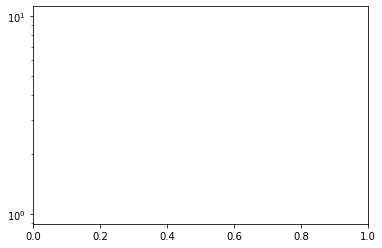

In [ ]:
plt.yscale("log")
plt.plot(range(len(losses)), losses)

Great. Now we've got an autoencoder, what do we do with it?

In [5]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14].to("cuda")

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden
        total += tokens.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [6]:
freqs = get_freqs(local_encoder=autoenc)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:17<00:00,  1.47it/s]

Num dead tensor(0.3965, device='cuda:0')


In [ ]:
tt(freqs)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (1024)


In [ ]:
print(freqs[112] * act_data.shape[0])

tensor(2202.3345, device='cuda:0')


Text(0, 0.5, 'Count of Features(neuron acts)')

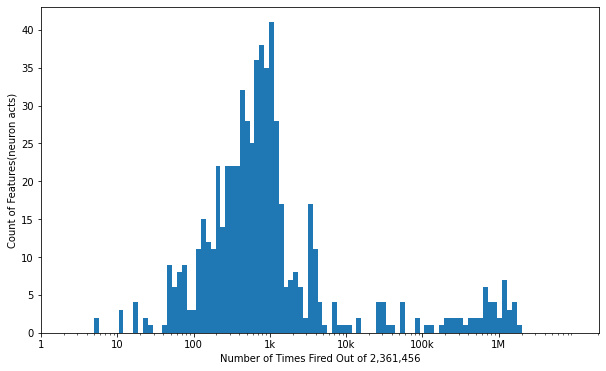

In [7]:
x = interpretability.numpy(freqs) * act_data.shape[0]
# x = interpretability.numpy(freqs)
x = x[np.isfinite(x)]
fig, ax = plt.subplots()
# set figure size
fig.set_size_inches(10, 6)
ax.hist(x, bins=np.logspace(np.log10(5), np.log10(10000000), 100))
ax.set_xscale("log")
# x label
# ax.xlabel("Number of Moves (log 10 scale)");
# y label
# ax.ylabel("Count of Features(neuron acts)");
# set xtick and labels of ticks
tick_positions = [1, 10, 100, 1000, 10000, 100000, 1000000]
tick_labels = ["1", "10", "100", "1k", "10k", "100k", "1M"]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
# ax.get_xaxis().set_major_formatter(plt.ScalarFormatter());
ax.set_xlabel("Number of Times Fired Out of 2,361,456")
ax.set_ylabel("Count of Features(neuron acts)")

In [8]:
torch.save(autoenc, "sparse_autoencoder_on_activations_07NOV2023.pt")